
# • Decision Trees

• Suggested reading: Chapter 9 of [The Elements of Statistical Learning](http://statweb.stanford.edu/~tibs/ElemStatLearn/)

### • Why decision trees?

- Can be applied to both regression and classification problems

- Many useful properties

- Very popular

- Basis for more sophisticated models


### • Lesson objectives

- Understand how a decision tree is created

- Build a decision tree model in `scikit-learn`

- Tune a decision tree model and explain how tuning impacts the model

- Generate and interpret a tree diagram

- Understand the key differences between regression and classification trees

# • Set up

In [1]:
#Don't conda install graphviz
#brew install graphviz

#if
#dyld: Library not loaded: /usr/lib/libltdl.7.dylib
#brew install libtool

#maybe
#sudo chown -R `whoami`:admin /usr/local/share/info
#sudo chown -R `whoami`:admin /usr/local/share/man/man5

In [2]:
import scipy.optimize as so
import scipy.stats as ss
import numpy as np
import pandas as pd
import sklearn.tree as st
import matplotlib.pyplot as plt
%matplotlib inline

# • Intuition

- Some part of our data may fit one model, the other part may fit a different model

- Ideally, we want to partition our data in some *systematic* way, and fit models individually for each part

- *how to partition data into N arbitary partitions? With N unknown (and need to be optimized)?*

- Binary partition, however, is very easy to implement

- Running binary partition iteratively gives you a branching tree-looking topology

# • Dummy variable example

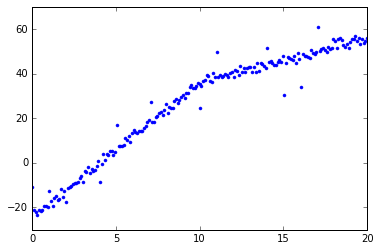

In [3]:
x1 = np.linspace(0,  10, 100)
x2 = np.linspace(10.001, 20, 100)
y1 = x1*6 - 24
y2 = x2*2 + 16

x  = np.hstack((x1, x2))
e  = np.random.normal(0, 1.2, x.shape)
y  = np.hstack((y1, y2)) + e
e2 = 30 * (0.5 - np.random.random(len(x)/10))
y[::10] += e2

plt.plot(x, y, '.')

# • Find the optimal 'split' point with a MSE loss function

In [4]:
def lin_reg_err(lm, x, y):
    '''return sum of square errors for a linear model'''
    return ((y - lm.slope*x - lm.intercept)**2).sum()

def split_reg_err(s, x, y):
    '''return sum of square errors for a split linear model'''
    x1, x2  = x[x <= s], x[x > s]
    y1, y2  = y[x <= s], y[x > s]
    lm1 = ss.linregress(x1, y1)
    lm2 = ss.linregress(x2, y2)
    return lin_reg_err(lm1, x1, y1) + lin_reg_err(lm2, x2, y2)

so.fmin_powell(split_reg_err, 5, args=(x, y))

Optimization terminated successfully.
         Current function value: 1669.287831
         Iterations: 2
         Function evaluations: 31


array(10.523705963054779)

# • Visualize the result

In [5]:
def lin_reg_pdt(lm, x, y):
    '''return prediction of a linear model'''
    return lm.slope*x + lm.intercept

def split_reg_pdt(s, x, y):
    '''return prediction of a split linear model'''
    x1, x2  = x[x <= s], x[x > s]
    y1, y2  = y[x <= s], y[x > s]
    lm1 = ss.linregress(x1, y1)
    lm2 = ss.linregress(x2, y2)
    return np.hstack((lm1.slope*x1 + lm1.intercept,
                      lm2.slope*x2 + lm2.intercept))

Simple Linear Regression MSE: 42.338
"Split" Linear Regression MSE: 8.445
Actual MSE: 1.602


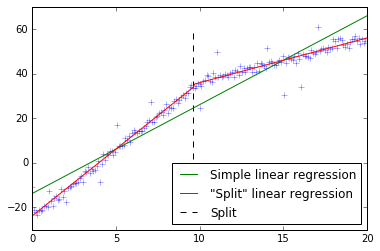

In [6]:
plt.plot(x, y, '+', alpha=0.6)

lm = ss.linregress(x, y)
split = 10.523705963054779

plt.plot(x, lin_reg_pdt(lm, x, y), 
         label = 'Simple linear regression')
plt.plot(x, split_reg_pdt(split, x, y), 
         label = '"Split" linear regression')
plt.vlines(split, -20, 60, 
          linestyle = '--', label = "Split")
plt.legend(loc='lower right')

print 'Simple Linear Regression MSE: %3.3f'%(lin_reg_err(lm, x, y)/len(x))
print '"Split" Linear Regression MSE: %3.3f'%(split_reg_err(split, x, y)/len(x))
print 'Actual MSE: %3.3f'%((e**2).sum()/len(x))

# • Congratulations! You just discovered:

- What is essentially a form of [Multivariate adaptive regression splines](https://en.wikipedia.org/wiki/Multivariate_adaptive_regression_splines)

- Decision Tree (Decision Tree Regression) is even simpler than the dummy example

- Instead of fitting a linear model $y=bx+c$, Decision Tree Regression only fits an intercept $c$ for each partition

- Running it iteratively gives you a tree

- Decision tree with binary response: Decision Tree Classification.

- Classification And Regression Tree (CART)

# • Decision Tree, the `sklearn` way

- Organized in `sklearn.tree` module.

- First, set up the learner (`DecisionTreeRegressor` or `DecisionTreeClassifier`)

- `.fit` your data.

In [7]:
tree_reg = st.DecisionTreeRegressor(max_depth=1)
tree_reg.fit(x.reshape(-1,1), y)

DecisionTreeRegressor(criterion='mse', max_depth=1, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

## • `.predict` your response and visualize the result.

## • export the resultant tree to a **[dot](https://en.wikipedia.org/wiki/DOT_(graph_description_language)** (graph description language) file.

## • `graphviz` converts `dot` file to image files

## • pay attention to `depth` parameter.

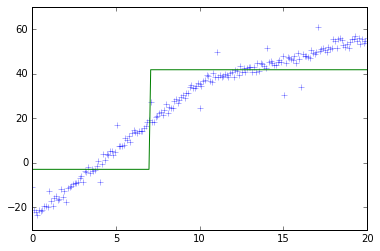

In [8]:
plt.plot(x, y, '+', alpha=0.6)

prd_1 = tree_reg.predict(x.reshape(-1,1))

plt.plot(x, prd_1, 
         label = 'Decision Tree Regressor')
st.export_graphviz(tree_reg, 'simple_reg_tree_1.dot')

# • What a `dot` file looks like.

    # %load simple_reg_tree_1.dot

```python
digraph Tree {
0 [label="X[0] <= 7.4242\nmse = 554.428946089\nsamples = 200", shape="box"] ;
1 [label="mse = 150.3456\nsamples = 74\nvalue = [-1.65037839]", shape="box"] ;
0 -> 1 ;
2 [label="mse = 90.1292\nsamples = 126\nvalue = [ 41.89576192]", shape="box"] ;
0 -> 2 ;
}
```

In [9]:
!dot -Tpng simple_reg_tree_1.dot -o simple_reg_tree_1.png

Simple Regression Tree

<img src="simple_reg_tree_1.png" alt="Simple Regression Tree" style="">

## • Multidimensional Decision Tree (more than 1 predictor) 

![](MD_Tree.png)

# • Improve fit with increasing `max_depth`

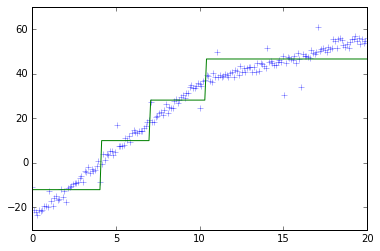

In [10]:
tree_reg.set_params(**{'max_depth': 2})
tree_reg.fit(x.reshape(-1,1), y)

plt.plot(x, y, '+', alpha=0.6)
prd_2 = tree_reg.predict(x.reshape(-1,1))
plt.plot(x, 
         prd_2, 
         label = 'Decision Tree Regressor')
st.export_graphviz(tree_reg, 'simple_reg_tree_2.dot')

In [11]:
!dot -Tpng simple_reg_tree.dot -o simple_reg_tree_2.png

Simple Regression Tree

<img src="simple_reg_tree_2.png" alt="Simple Regression Tree" style="">

# • Potential overfit with increasing `max_depth`

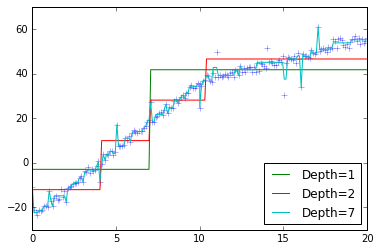

In [12]:
tree_reg.set_params(**{'max_depth': 7})
tree_reg.fit(x.reshape(-1,1), y)

plt.plot(x, y, '+', alpha=0.6)
prd_7 = tree_reg.predict(x.reshape(-1,1))

for depth in [1,2,7]:
    plt.plot(x, 
             eval('prd_%s'%depth), 
             label = 'Depth=%s'%depth)

plt.legend(loc='lower right')

# • Avoid overfit

# • Prune your tree!

Unfortunately not yet available in `sklearn` https://github.com/scikit-learn/scikit-learn/pull/941

# • Control `max_depth` using cross validation

# • Use the built-in `diabetes` dataset as an example

In [13]:
from sklearn.cross_validation import cross_val_score
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()

tree_reg = st.DecisionTreeRegressor()
tree_reg.fit(diabetes.data, diabetes.target)

cv_error = []
for depth in range(1, 10):
    tree_reg.set_params(**{'max_depth': depth})
    cv_error.append(np.sqrt(-cross_val_score(tree_reg, diabetes.data,diabetes.target,
                                             cv=14, scoring='mean_squared_error')))

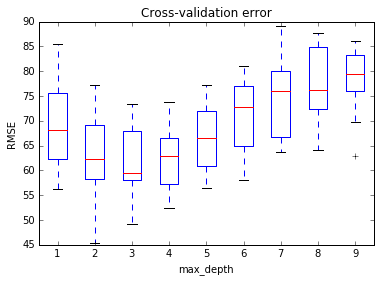

In [14]:
df = pd.DataFrame(np.vstack(cv_error).T)
df.plot(kind='box')
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.title('Cross-validation error')
_ = plt.xticks(range(1, 10), map(str, range(1,10)))

# • Classification Tree v.s. Regression Tree

In [15]:
from sklearn.datasets import load_iris
iris = load_iris()
tree_clf = st.DecisionTreeClassifier()
tree_clf.fit(iris.data, iris.target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

## • Different loss functions (node impurity function)

> `criterion : string, optional (default="gini")`
> `   The function to measure the quality of a split. Supported criteria are`
> `   "gini" for the Gini impurity and "entropy" for the information gain.`

<img src="impurity_fig.png" alt="Multidimensional Decision Tree Tree" height="100" width="700">
<img src="impurity_fml.png" alt="Multidimensional Decision Tree Tree" height="100" width="700">

# • Making better tree graphs

In [16]:
print type(iris)
print isinstance(iris, dict)
print iris.keys()

<class 'sklearn.datasets.base.Bunch'>
True
['target_names', 'data', 'target', 'DESCR', 'feature_names']


In [17]:
st.export_graphviz(tree_clf, out_file='iris.dot',  
                   feature_names=iris.feature_names,  
                   class_names=iris.target_names,  
                   filled=True, rounded=True,  
                   special_characters=True) 

In [18]:
!dot -Tpng iris.dot -o iris.png

# • Nice looking customized tree graph

<img src="iris.png" alt="Simple Regression Tree" style="">

# • Access the properties of your tree

In [19]:
tree_clf.tree_.impurity

array([ 0.66666667,  0.        ,  0.5       ,  0.16803841,  0.04079861,
        0.        ,  0.        ,  0.44444444,  0.        ,  0.44444444,
        0.        ,  0.        ,  0.04253308,  0.44444444,  0.        ,
        0.        ,  0.        ])

In [20]:
pd.DataFrame({'feature':iris.feature_names, 
              'importance':tree_clf.feature_importances_})

,feature,importance
0,sepal length (cm),0.000000
1,sepal width (cm),0.013333
2,petal length (cm),0.064056
3,petal width (cm),0.922611


# • Pros and Cons of decision tree
    
| **Pros** | **Cons** |
|---|---|
| Popular real-world data mining algorithm | Can generate large trees that require pruning |
| Response can be numerical or categorical variables | Generally poorer predictive power than ANN, SVM or kNN |
| Interpretable, white box model | Can overfit |
| Robust to outliers, noisy or redundant attributes | Many adjustable parameters |
| Good computational scalability |   |
| No need to worry about interactions|   |
| Automatically does varible selection for you  |   |

# • What do you can a large number of trees? *Forest*

• Emsemble methods: Random Forest